In [2]:
import sys
sys.path.append('..')
from load_datasets import load_image, show_image_with_bbox, show_image_with_two_bboxes

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split

import tensorflow as tf

2023-12-21 03:57:44.250163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
root = '../../datasets/ADAM/Training1200'
fovea = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')

display(fovea.head())
display(fovea.tail())

,imgName,Fovea_X,Fovea_Y
ID,,,
0,A0001.jpg,142.495130,127.255264
1,A0001-1.jpg,173.229593,152.780556
2,A0001-2.jpg,142.495130,127.255264
3,A0002.jpg,116.640789,126.623708
4,A0002-1.jpg,116.640789,129.376292


,imgName,Fovea_X,Fovea_Y
ID,,,
1180,N0310-1.jpg,121.887742,147.226449
1181,N0310-2.jpg,121.887742,147.226449
1182,N0311.jpg,132.273929,134.670017
1183,N0311-1.jpg,132.273929,134.670017
1184,N0311-2.jpg,132.273929,134.670017


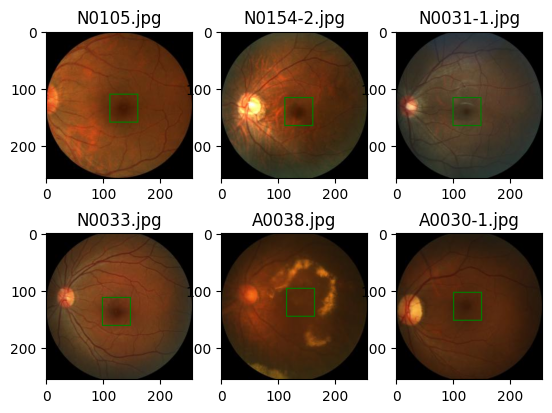

In [4]:
fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(fovea.index, size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = load_image(fovea, idx, root=root)
	show_image_with_bbox(fovea, img, bbox, ax=ax, idx=idx)

In [5]:
def build_adam_dataset(df, image_size=256):
	imgs, bboxes = [], []

	for idx in df.index:
		img, bbox = load_image(df, idx)

		img_arr = np.array(img)#.transpose((2,0,1))
		imgs.append(img_arr)

		bbox_arr = np.array(bbox)
		bboxes.append(bbox_arr)

	img_tensor = np.stack(imgs).astype(np.float32) / 255 # uint8::max
	bbox_tesor = np.stack(bboxes).astype(np.float32) / image_size # image size

	return tf.data.Dataset.from_tensor_slices((img_tensor, bbox_tesor))


def get_adam_loaders(batch_size, test_batch_size=None, image_size=256, cutoff=1.0, root='../../datasets/ADAM/Training1200'):
	if not test_batch_size: test_batch_size = batch_size * 2

	fovea_df = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')
	train_df, test_df = train_test_split(fovea_df, test_size=1-cutoff, shuffle=True)

	train_ds = build_adam_dataset(train_df, image_size).shuffle(buffer_size=1024).batch(batch_size)
	test_ds = build_adam_dataset(test_df, image_size).batch(test_batch_size)

	return train_ds, test_ds

In [6]:
train_ds, test_ds = get_adam_loaders(8, 16, cutoff=0.8)
img_batch, bbox_batch = next(iter(train_ds))
print(img_batch.shape, img_batch.dtype)
print(bbox_batch, bbox_batch.dtype)

2023-12-21 03:57:47.834774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 03:57:47.927491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 03:57:47.928051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(8, 256, 256, 3) <dtype: 'float32'>
tf.Tensor(
[[0.44070983 0.43553817]
 [0.75542736 0.66049844]
 [0.6437793  0.6164856 ]
 [0.47283554 0.5026946 ]
 [0.52842695 0.5309454 ]
 [0.47056276 0.52669144]
 [0.48518538 0.56608945]
 [0.5940462  0.62205577]], shape=(8, 2), dtype=float32) <dtype: 'float32'>


In [7]:
class ResBlock(tf.keras.Model):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		self.base1 = tf.keras.Sequential([
			tf.keras.layers.Conv2D(in_channels, 3, padding="same"),
			tf.keras.layers.BatchNormalization(),
			tf.keras.layers.ReLU()
		])


		self.base2 = tf.keras.Sequential([
			tf.keras.layers.Conv2D(out_channels, 3, padding="same"),
			tf.keras.layers.BatchNormalization(),
			tf.keras.layers.ReLU()
		])


	def call(self, x):
		x = self.base1(x) + x
		x = self.base2(x)
		return x

In [8]:
resblock = ResBlock(3, 16)
resblock.build(input_shape=(None, 256, 256, 3))
resblock.summary()

Model: "res_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       96        
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 16)      512       
                                                                 
Total params: 608 (2.38 KB)
Trainable params: 570 (2.23 KB)
Non-trainable params: 38 (152.00 Byte)
_________________________________________________________________


In [15]:
def SODNetBuilder(in_channels, first_output_channels):
	return tf.keras.Sequential([
		tf.keras.Input(shape=(256, 256, 3)),

		ResBlock(in_channels, first_output_channels),
		tf.keras.layers.MaxPool2D((2,2)),

		ResBlock(first_output_channels, 2 * first_output_channels),
		tf.keras.layers.MaxPool2D((2,2)),

		ResBlock(2 * first_output_channels, 4 * first_output_channels),
		tf.keras.layers.MaxPool2D((2,2)),

		ResBlock(4 * first_output_channels, 8 * first_output_channels),
		tf.keras.layers.MaxPool2D((2,2)),
		
		tf.keras.layers.Conv2D(16 * first_output_channels, 3),
		tf.keras.layers.MaxPool2D((2,2)),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(2),
	])

In [16]:
model = SODNetBuilder(3, 16)
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block_14 (ResBlock)     (None, 256, 256, 16)      608       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 128, 128, 16)      0         
 ng2D)                                                           
                                                                 
 res_block_15 (ResBlock)     (None, 128, 128, 32)      7152      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 res_block_16 (ResBlock)     (None, 64, 64, 64)        28128     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 32, 32, 64)      